In [2]:
import pandas as pd
import numpy as np
import os, sys
sys.path.append("../")
sys.path.append("../../")

# 경고 메세지 off
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import silhouette_score # 성능 지표를 계산하기 위해 silhouette_score import
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
SEED=23
from Clust.clust.ML.clustering.kMeans import KMeansTrain, KMeansTest

In [3]:
# Data load
address = './../data_processing/Dataset/'
data = pd.read_csv(os.path.join(address,'df_pm10_7day_result_1110.csv'), header = 0, encoding='cp949')

In [4]:
# in_serial = 장소 정보와 in_id =data sample id만 data_cd로 생성
data_cd = data[['in_serial','in_id']]

In [5]:
data_cd = data_cd.drop_duplicates().set_index(keys='in_id')
# 클러스터링을 진행하기 위해 data table 형태 변환
df_pivot = pd.DataFrame()
for in_data_cd in data['in_id'].unique():
    sample = data[data['in_id'] == in_data_cd]
    time_index = []
    for i in range(0,len(sample)):
        time_index.append(i)
    sample['time_index'] = time_index
    df_pivot = pd.concat([df_pivot,sample], ignore_index=True)
df_pivot= df_pivot.pivot_table(index="time_index", columns="in_id", values="in_pm10_day")

#  1. 1일 데이터로 자르기

In [6]:
data_origin = df_pivot.loc[:143]
data_origin

in_id,ICL1L2000011,ICL1L2000017,ICL1L2000064,ICL1L2000065,ICL1L2000234,ICL1L2000235,ICL1L2000236,ICL1L2000237,ICL1L2000238,ICL1L2000239,...,ICW0W2100277,ICW0W2100278,IS70W2000822,IS70W2000851,IS70W2000852,IS70W2000853,IS70W2000854,IS70W2000855,IS70W2000856,IS70W2000858
time_index,,,,,,,,,,,,,,,,,,,,,
0,21.5,11.4,15.3,16.2,43.3,29.1,18.6,23.5,61.0,52.7,...,3.0,3.2,98.97,9.9,5.0,5.9,0.7,8.7,14.1,12.6
1,22.3,11.3,15.2,16.2,43.5,28.8,18.5,23.3,60.9,52.5,...,3.2,3.8,98.94,8.5,5.0,6.2,1.0,9.5,14.6,12.2
2,21.8,11.3,16.1,16.6,42.5,27.8,18.6,23.7,60.6,52.5,...,3.4,3.3,98.76,8.2,4.4,6.0,0.7,8.9,13.8,12.3
3,21.5,11.5,14.5,16.7,41.9,27.0,19.0,23.6,60.4,52.6,...,3.4,3.7,98.42,8.2,4.5,5.6,0.8,9.0,13.1,12.2
4,21.5,11.1,16.9,16.9,42.2,27.5,18.5,23.8,60.2,52.0,...,3.6,3.8,98.59,6.9,5.4,5.6,0.7,6.9,11.7,12.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,40.0,13.4,41.7,16.7,23.5,3.0,58.9,19.1,64.7,24.0,...,8.7,7.5,96.94,2.0,3.0,1.3,7.2,0.8,3.8,7.3
140,39.2,13.4,41.1,16.9,23.7,2.8,57.8,19.6,65.3,22.3,...,8.1,7.8,96.91,1.8,3.0,1.6,6.9,0.7,2.6,6.8
141,45.4,13.1,40.5,17.0,23.0,2.7,57.5,19.4,65.0,22.0,...,8.6,7.1,97.21,2.2,2.4,2.0,7.4,0.7,4.1,6.2


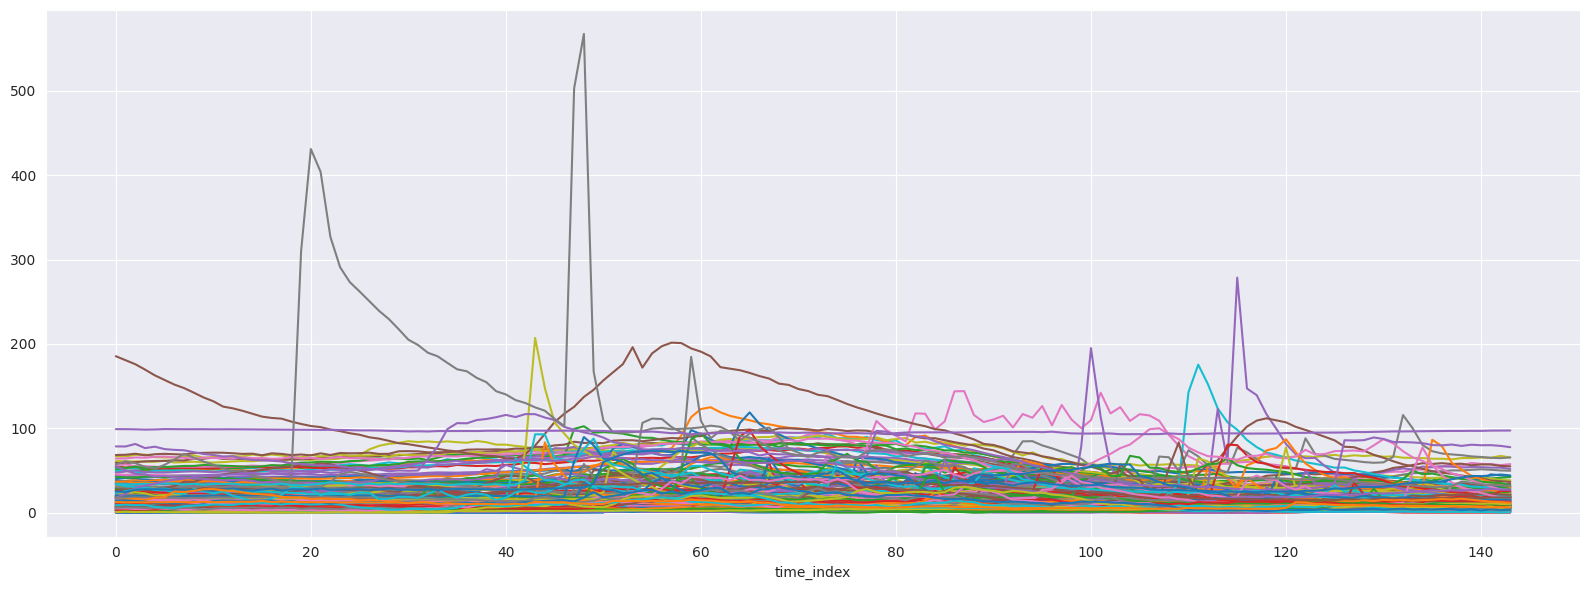

In [7]:
data_origin.plot(legend = False, figsize=(16,6))
plt.tight_layout()
plt.show()

#  2. 각 컬럼 데이터 NaN 데이터 처리

In [8]:
data = data_origin.interpolate(method='linear') 
print("NaN processing (count):", np.isnan(data_origin.values).sum(), "->", np.isnan(data.values).sum())

NaN processing (count): 45 -> 0


In [9]:
# Scaling
from sklearn.preprocessing import StandardScaler # 데이터 정규화에 사용할 StandardScaler import
scaler = StandardScaler() # StandardScaler 정규화 객체 생성
value = scaler.fit_transform(data)
data_scaled = pd.DataFrame(value, columns = list(data.columns))

In [10]:
data_scaled

,ICL1L2000011,ICL1L2000017,ICL1L2000064,ICL1L2000065,ICL1L2000234,ICL1L2000235,ICL1L2000236,ICL1L2000237,ICL1L2000238,ICL1L2000239,...,ICW0W2100277,ICW0W2100278,IS70W2000822,IS70W2000851,IS70W2000852,IS70W2000853,IS70W2000854,IS70W2000855,IS70W2000856,IS70W2000858
0,0.281009,-1.083745,-1.486973,-0.946086,0.077846,0.912305,-0.670812,-0.029019,-0.672148,-0.179370,...,-1.246727,-1.474897,1.779806,-0.104093,-0.604253,-0.594514,-0.996550,0.150634,0.139622,1.031154
1,0.340373,-1.098993,-1.502893,-0.946086,0.091822,0.885451,-0.679847,-0.096419,-0.684254,-0.189042,...,-1.218355,-1.341935,1.762534,-0.258032,-0.604253,-0.554596,-0.962624,0.297831,0.208163,0.904459
2,0.303270,-1.098993,-1.359613,-0.874621,0.021944,0.795937,-0.670812,0.038380,-0.720569,-0.189042,...,-1.189982,-1.452737,1.658905,-0.291019,-0.652215,-0.581208,-0.996550,0.187433,0.098498,0.936133
3,0.281009,-1.068497,-1.614333,-0.856754,-0.019982,0.724327,-0.634671,0.004681,-0.744780,-0.184206,...,-1.189982,-1.364095,1.463161,-0.291019,-0.644222,-0.634431,-0.985241,0.205833,0.002542,0.904459
4,0.281009,-1.129489,-1.232253,-0.821022,0.000981,0.769083,-0.679847,0.072080,-0.768991,-0.213222,...,-1.161609,-1.341935,1.561033,-0.433961,-0.572279,-0.634431,-0.996550,-0.180562,-0.189372,0.967807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.653791,-0.778785,2.715910,-0.856754,-1.305724,-1.423991,2.970396,-1.511812,-0.224252,-1.567338,...,-0.438103,-0.522000,0.611100,-0.972746,-0.764126,-1.206584,-0.261506,-1.302945,-1.272310,-0.647551
140,1.594427,-0.778785,2.620390,-0.821022,-1.291748,-1.441894,2.871008,-1.343313,-0.151621,-1.649552,...,-0.523222,-0.455519,0.593828,-0.994737,-0.764126,-1.166666,-0.295431,-1.321345,-1.436807,-0.805919
141,2.054495,-0.824529,2.524870,-0.803156,-1.340662,-1.450845,2.843903,-1.410713,-0.187937,-1.664061,...,-0.452290,-0.610642,0.766543,-0.950754,-0.812087,-1.113442,-0.238889,-1.321345,-1.231186,-0.995961
142,1.972870,-0.794033,2.652230,-0.928220,-1.410539,-1.477699,2.735480,-1.410713,0.078380,-1.668897,...,-0.551594,-0.654963,0.806844,-0.939759,-0.772119,-1.086831,-0.465056,-1.413343,-1.354559,-0.869266


#  3. Clustering
## 3-1. Clustering 파라미터를 정하기 위한 단계

In [11]:
kmeans_metrics_list =['euclidean', 'dtw', 'softdtw']
kmeans_metrics = kmeans_metrics_list[1]

In [12]:
max_clusters = 9
param = {"n_clusters":max_clusters, "metric":kmeans_metrics}

kMeans_i = KMeansTrain(param) 

# 1. 데이터 준비
data_series = kMeans_i.make_input_data(data_scaled)
data_name = list(data_scaled.columns)

# 2. Train
metrics = kMeans_i.search_best_n_clust(data_series, max_clusters)

  0%|          | 0/7 [00:00<?, ?it/s]

TypeError: plot_ts_by_label() takes 1 positional argument but 6 were given

In [ ]:
metrics[["silhouette_score"]].plot()
plt.show()
metrics[["distortion_score"]].plot()
plt.show()

## 3-3. Clustering Model 활용

## 3-2. Clustering Model 생성 및 저장 (인출)

In [ ]:
n_clusters = 3
param = {"n_clusters":n_clusters, "metric":kmeans_metrics}
kMeans_i = KMeansTrain(param) 

# 1. 데이터 준비
data_series = kMeans_i.make_input_data(data_scaled)
data_name = list(data_scaled.columns)

# 2. Train
kMeans_i.train(data_series)
model = kMeans_i.model

#important code for external usage
# 3. model save 
file_name = "model.pkl"
kMeans_i.save_model(file_name)

kMeans_t = KMeansTest()

#5. Test
#important code for external usage
#4. model Load
file_name = "model.pkl"
model = kMeans_t.load_model(file_name)
kMeans_t.set_model(model)

# TODO Hard Coding 삭제해야함 (som_x, som_y 를 인풋으로 넣으면 안됨, minsiSom 참고 바람)
result = kMeans_t.predict(data_series) 
result_dic = kMeans_t.get_dict_from_two_array(data_name, result)

plt1 = kMeans_t.plot_ts_by_label(n_clusters, data_series, result, kmeans_metrics, kMeans_t.model)
plt.show()

## 3-4. Clustering 결과 확인 (Train, Test)

In [ ]:
from Clust.clust.transformation.featureReduction.pca import show_clustering_result_by2DPCA
data_2d = show_clustering_result_by2DPCA(data_series, result)

In [ ]:
from Clust.clust.ML.tool.util import count_label_info
count = count_label_info(result)
print(count)